<a href="https://colab.research.google.com/github/BobGanti/ColabNotebooks/blob/main/LingualXplorerEn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GLOBAL SETUP SECTION

### Connect Drive and load datasets

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

### Funciton to Return DataFrame by Language

In [ ]:
def get_dataset_by_language(df, lang_code):
    if lang_code != 'all':
        return df[df['language'] == lang_code]
    return df


### Training Config: Setting batch size, epoch, train lang, etc.

In [ ]:
# Global Train/Validate variables
CONFIG = {
    'train_batch_size': 16,
    'train_epochs': 3,
    'train_lang': 'en',
    'lang_dict': {'ar':'Arabic','bg':'Bulgarian','de':'German','el':'Greek','en':'English',
             'es':'Spanish','fr':'French','hi':'Hindi','ru':'Russian','sw':'Swahili',
             'th':'Thai','tr':'Turkish','ur':'Urdu','vi':'Vietnamese','zh':'Chinese'
            }
}

### Tokenization Function: returns tokenized sentence1 and sentence2

In [ ]:
# Tokenisation function
def tokenize_sequence(df, tokenizer):
    return tokenizer(df['sentence1'].tolist(), df['sentence2'].tolist(), padding=True, truncation=True, return_tensors="pt")


# TRAINING AND VALIDATION SECTION

### Loading the dev dataset for the chosen language to use for Training.

In [ ]:
import pandas as pd

dev_df = pd.read_csv('/content/drive/MyDrive/Datasets/XNLI-1.0/XNLI-1.0/xnli.dev.tsv', delimiter='\t', usecols=['language','sentence1','sentence2','gold_label'])

lang = CONFIG['train_lang']
dev_df = get_dataset_by_language(dev_df, lang)

### Map Encoding categorical values in the target column

In [ ]:

# Convert gold labels to numerical format
label_mapping = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
dev_df['gold_label_numeric'] = dev_df['gold_label'].map(label_mapping)


### Split the dev dataset into train and validation, separate inputs X, target y

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the dataset (80% train, 20% validation)
train_df, val_df = train_test_split(dev_df, test_size=0.2, random_state=42)

# Separating the inputs X and target y.
X_train = train_df[['sentence1', 'sentence2']]
y_train = train_df['gold_label_numeric']

X_val = val_df[['sentence1', 'sentence2']]
y_val = val_df['gold_label_numeric']


### Instantiate the Tokenization object with the pretrained tokeniser from **Huggingface** and pass to the tokenization function, together with the train and val inputs

In [ ]:
from transformers import AutoTokenizer

pretrained_model = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

# Tokenise the training, validation, and test inputs
tokenized_train = tokenize_sequence(X_train, tokenizer)
tokenized_val = tokenize_sequence(X_val, tokenizer)


### Instantiate the Model object from the pretrained Model from Huggingface

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

### Tensor datasets and DataLoaders

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert tokenised data into TensorDataset
train_dataset = TensorDataset(tokenized_train['input_ids'], tokenized_train['attention_mask'], torch.tensor(y_train.tolist()))
val_dataset = TensorDataset(tokenized_val['input_ids'], tokenized_val['attention_mask'], torch.tensor(y_val.tolist()))

# Create DataLoaders
batch_size = CONFIG['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


### Training and Validation Loops

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

 # Loss function and optimizer
loss_function = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = CONFIG['train_epochs']

# Learning rate scheduler (optional)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

for epoch in range(num_epochs):
    # Training Phase ###############
    model.train()
    train_loss = 0

    lang = CONFIG['train_lang']
    train_bar = tqdm(train_loader, desc=f"Training in {CONFIG['lang_dict'][lang]}. Epoch:{epoch+1}/{num_epochs}")

    for batch in train_bar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_function(outputs.logits, labels)

        # Backward pass and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Average Training Loss: {avg_train_loss:.4f}")

    # Update learning rate
    scheduler.step()

    # * VALIDAGTION PHASE **********************
    model.eval()
    val_predictions = []
    val_true_labels = []

    val_bar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}") # Initialise the progress bar.

    with torch.no_grad():
        for batch in val_bar:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            val_predictions.extend(np.argmax(logits, axis=1).flatten())
            val_true_labels.extend(label_ids.flatten())

        val_accuracy = accuracy_score(val_true_labels, val_predictions)
        print(f"Epoch {epoch+1}/{num_epochs} - Validation Accuracy: {val_accuracy:.4f}")


Training in English Epoch:1/3: 100%|██████████| 125/125 [00:49<00:00,  2.52it/s, loss=0.0196]


Epoch 1/3 - Average Training Loss: 0.0625


Validation Epoch 1/3: 100%|██████████| 32/32 [00:03<00:00,  9.79it/s]


Epoch 1/3 - Validation Accuracy: 0.9920


Training in English Epoch:2/3: 100%|██████████| 125/125 [00:50<00:00,  2.46it/s, loss=0.0237]


Epoch 2/3 - Average Training Loss: 0.0175


Validation Epoch 2/3: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s]


Epoch 2/3 - Validation Accuracy: 0.9940


Training in English Epoch:3/3: 100%|██████████| 125/125 [00:50<00:00,  2.48it/s, loss=0.00317]


Epoch 3/3 - Average Training Loss: 0.0091


Validation Epoch 3/3: 100%|██████████| 32/32 [00:03<00:00,  9.53it/s]

Epoch 3/3 - Validation Accuracy: 0.9940


### Save the Trained Model Local Dir

In [ ]:
# tokenizer.save_pretrained("/content/drive/MyDrive/Colab Notebooks/pretrained_english_tokenizer")

# torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/pretrained_english_modelstate')


 # TESTING SECTION

### Choose test language dataset

### Get Label from Label Id Function

In [ ]:
def get_label(label_id):
    label_dict = {0: "entailment", 1: "neutral", 2: "contradiction"}
    return label_dict[label_id]

### Load Local Model and its Token Configs

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")

# Retrieve the saved tokenised configurations
test_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Colab Notebooks/pretrained_english_tokenizer")

# Instantiate a model with the same configuration used during training
model = AutoModelForSequenceClassification.from_pretrained(
    "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7",
    num_labels=3
)
model.to(device)

# Load the saved state dictionary
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/pretrained_english_modelstate"))


<All keys matched successfully>

### Load Entire Test dataset

In [ ]:
import pandas as pd

def load_test_data(lang):
    test_data = pd.read_csv('/content/drive/MyDrive/Datasets/XNLI-1.0/XNLI-1.0/xnli.test.tsv', delimiter='\t',usecols=['language','sentence1','sentence2','gold_label'])

    if lang != 'all':
        df = get_dataset_by_language(test_data, lang)
    else:
        df = test_data
    return df


### Fetch Chosen Language Dataset from entire dataset, Tokenize Sequences and create test_loader function

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch

def create_loader(t_df, batch_size):
    label_mapping = {"entailment":0, "neutral":1, "contradiction":2}
    t_df = t_df.copy()
    t_df['gold_label_numeric'] = t_df['gold_label'].map(label_mapping)

    y_test = t_df['gold_label_numeric']
    X_test = t_df[['sentence1', 'sentence2']]

    tokenized_test = tokenize_sequence(X_test, test_tokenizer)

    # Convert tokenised data into TensorDataset
    test_dataset = TensorDataset(tokenized_test['input_ids'], tokenized_test['attention_mask'], torch.tensor(y_test.tolist()))

    # Create DataLoaders
    loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return loader


## Test Loop

### Run Test On Chosen Language

In [ ]:
import numpy as np
from tqdm import tqdm

# Set the model to evaluation mode
model.eval()

# Initialize variables
actual_labels = []
predicted_labels = []
av_accuracies = []
test_accuracy = 0
nb_test_steps = 0

num_epochs = 2
lang = 'sw'
full_lang = CONFIG['lang_dict'][lang]
batch_size = 32

test_df = load_test_data(lang)

test_loader = create_loader(test_df, batch_size)
for epoch in range(num_epochs):
    test_bar = tqdm(test_loader, desc=f"Testing in {full_lang} epoch:{epoch+1}/{num_epochs}")
    with torch.no_grad():
        for i, batch in enumerate(test_bar):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            # Forward pass
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Save predictions and actual labels
            actual_labels.extend(label_ids)
            predictions = np.argmax(logits, axis=1)
            predicted_labels.extend(predictions)

            # Calculate and accumulate accuracy
            tmp_test_accuracy = np.mean(predictions == label_ids)
            test_accuracy += tmp_test_accuracy
            nb_test_steps += 1

        # Calculate final accuracy
        final_test_accuracy = test_accuracy / nb_test_steps
        av_accuracies.append(final_test_accuracy)
        print(f"epoch accuracy:{final_test_accuracy:.4f}")
print(f"Av. Accuracy:{(sum(av_accuracies)/len(av_accuracies)):.4f}")


Testing in Swahili epoch:1/2: 100%|██████████| 157/157 [00:44<00:00,  3.51it/s]


epoch accuracy:0.7435


Testing in Swahili epoch:2/2: 100%|██████████| 157/157 [00:45<00:00,  3.42it/s]

epoch accuracy:0.7435
Av. Accuracy:0.7435


### Print out ome Samples

In [ ]:
from sklearn.metrics import classification_report
test_samples = 10
 # Print requested number of examples
for i in range(test_samples):
    print(f"Example {i + 1}:")
    print(f"Sentence 1: {test_df.iloc[i]['sentence1']}")
    print(f"Sentence 2: {test_df.iloc[i]['sentence2']}")
    print(f"Predicted label: {get_label(predicted_labels[i])}")
    print(f"Actual label: {get_label(actual_labels[i])}")
    print("\n")


Example 1:
Sentence 1: Naam, sikukuwa nafikiri juu ya hilo, lakini nilichanganyikiwa sana, na, hatimaye nikaendelea kuzungumza naye tena.
Sentence 2: Sijaongea na yeye tena.
Predicted label: contradiction
Actual label: contradiction


Example 2:
Sentence 1: Naam, sikukuwa nafikiri juu ya hilo, lakini nilichanganyikiwa sana, na, hatimaye nikaendelea kuzungumza naye tena.
Sentence 2: Nilikasirika sana kwamba nikaanza kuzungumza naye tena.
Predicted label: entailment
Actual label: entailment


Example 3:
Sentence 1: Naam, sikukuwa nafikiri juu ya hilo, lakini nilichanganyikiwa sana, na, hatimaye nikaendelea kuzungumza naye tena.
Sentence 2: Tulikuwa na majadiliano mazuri.
Predicted label: neutral
Actual label: neutral


Example 4:
Sentence 1: Nami nilifikiri kwamba ilikuwa ni fursa, na bado, bado, nilikuwa pekee wa tisa mbili na mbili Ex-O ambayo ilikuwa uwanja wangu wa AFFC Air Force Career.
Sentence 2: Sikujua kwamba sikuwa mtu wa pekee kuwa uwanjani leo.
Predicted label: contradiction


## LOOP TEST FOR ALL LANGUAGES.

In [ ]:
import torch
from sklearn.metrics import classification_report
import pandas as pd

# Assuming test_df includes a 'language' column
languages = test_df['language'].unique()
metrics_dict = {}

# Initialize dictionaries for predictions and actual labels
language_predictions = {lang: [] for lang in languages}
language_actuals = {lang: [] for lang in languages}
num_epochs = 1
batch_size = 32
langu = 'th'

model.eval()
with torch.no_grad():
    test_df = load_test_data(langu)
    test_loader = create_loader(test_df, batch_size)
    for epoch in range(num_epochs):
        test_bar = tqdm(test_loader, desc=f"Testing All. epoch:{epoch+1}/{num_epochs}")
        for i, batch in enumerate(test_bar):
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            # Move predictions and labels back to CPU
            predictions = predictions.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Associate predictions with languages using indices in test_df
            for idx, pred in enumerate(predictions):
                actual = label_ids[idx]
                lang = test_df.iloc[i * test_loader.batch_size + idx]['language']
                language_predictions[lang].append(pred)
                language_actuals[lang].append(actual)
        print("\n")
        # Calculate and print performance metrics for each language
        for lang in languages:
            report = classification_report(language_actuals[lang], language_predictions[lang], output_dict=True)
            metrics_dict[lang] = report
            print(f"Performance Metrics for {CONFIG['lang_dict'][lang]} on {CONFIG['lang_dict'][CONFIG['train_lang']]} Trained Model")

            f1_scores = {lang: metrics_dict[lang]['weighted avg']['f1-score'] for lang in languages}
            print("F1 Scores by Language:", f1_scores)

            print("\n")
    print(metrics_dict)



Testing All. epoch:1/1: 100%|██████████| 157/157 [00:39<00:00,  3.99it/s]



Performance Metrics for Thai on English Trained Model
F1 Scores by Language: {'th': 0.7756858006167148}


{'th': {'0': {'precision': 0.7977099236641222, 'recall': 0.7508982035928143, 'f1-score': 0.7735965453423813, 'support': 1670}, '1': {'precision': 0.6961149547631719, 'recall': 0.7832335329341318, 'f1-score': 0.7371090448013524, 'support': 1670}, '2': {'precision': 0.8454137267479154, 'recall': 0.7892215568862275, 'f1-score': 0.8163518117064106, 'support': 1670}, 'accuracy': 0.7744510978043913, 'macro avg': {'precision': 0.7797462017250698, 'recall': 0.7744510978043913, 'f1-score': 0.7756858006167148, 'support': 5010}, 'weighted avg': {'precision': 0.7797462017250698, 'recall': 0.7744510978043913, 'f1-score': 0.7756858006167148, 'support': 5010}}}


## VISUALISATION SECTION

### Performance Metrics Graph



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

languages = []
for k, v in CONFIG['lang_dict'].items():
    languages.append(v)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
f1_scores = {lang: metrics_dict[lang]['weighted avg']['f1_score'] for lang in languages}
data = np.random.rand(4, len(languages))

fig, ax = plt.subplots()
bar_width = 0.2
opacity = 0.8

for i in range(len(metrics)):
    plt.bar(np.arange(len(languages)) + i * bar_width, data[i], bar_width, alpha=opacity, label=metrics[i])

plt.xlabel('Language')
plt.ylabel('Scores')
plt.title('Model Performance Metrics by Language')
plt.xticks(np.arange(len(languages)) + bar_width, languages)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



import matplotlib.pyplot as plt
import numpy as np

languages = ['English', 'Spanish', 'French', 'Chinese', 'Arabic', 'Yoruba', 'Fulfulde', 'Hausa']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
data = np.random.rand(4, len(languages))  # Replace with actual data

fig, ax = plt.subplots()
bar_width = 0.2
opacity = 0.8

for i in range(len(metrics)):
    plt.bar(np.arange(len(languages)) + i * bar_width, data[i], bar_width, alpha=opacity, label=metrics[i])

plt.xlabel('Language')
plt.ylabel('Scores')
plt.title('Model Performance Metrics by Language')
plt.xticks(np.arange(len(languages)) + bar_width, languages)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


KeyError: ignored

### Accuracy Graph

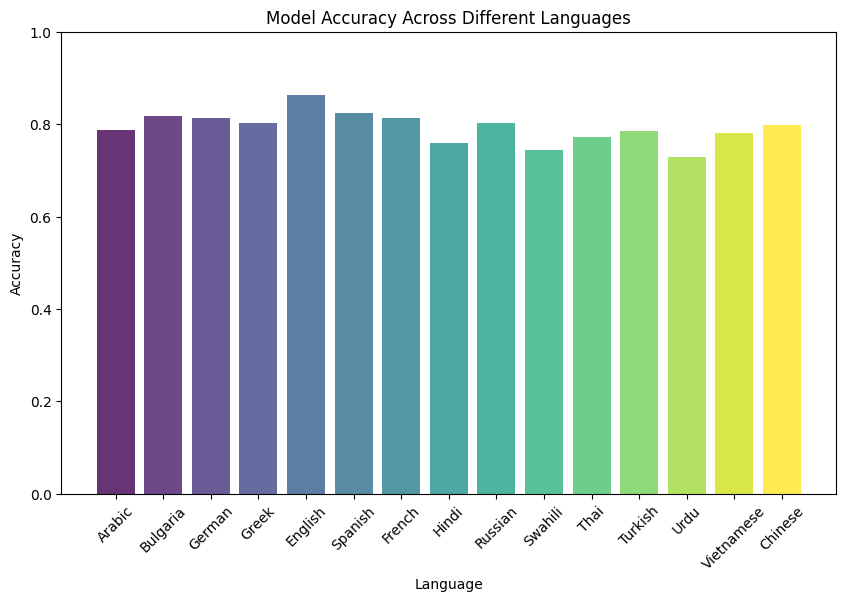

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

languages = ['Arabic', 'Bulgaria','German','Greek','English','Spanish','French',
             'Hindi','Russian','Swahili','Thai','Turkish','Urdu', 'Vietnamese','Chinese']
accuracies = [0.7873, 0.8169, 0.8139, 0.8027, 0.8626, 0.8237, 0.8142, 0.7595, 0.8016, 0.7443, 0.7721, 0.7849, 0.7297, 0.7816, 0.7989]
colours = colors = plt.cm.viridis(np.linspace(0, 1, len(languages)))
#  ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'red', 'black', 'purple', 'magenta',
#            'skyblue', 'grey', 'darkred', 'purple', 'yellow']

plt.figure(figsize=(10, 6))
plt.bar(languages, accuracies, color=colours, alpha=0.8)
plt.xlabel('Language')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Across Different Languages')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Set y-axis limit to show accuracy range from 0 to 1
plt.show()

### Language-specific Performance Heatmap

In [ ]:
import seaborn as sns
import numpy as np

# Synthetic data for demonstration, replace with actual model performance data
performance_data = np.random.rand(len(languages), len(languages))

plt.figure(figsize=(10, 8))
sns.heatmap(performance_data, annot=True, cmap='coolwarm', xticklabels=languages, yticklabels=languages)
plt.title('Language-Specific Performance Heatmap')
plt.xlabel('Test Language')
plt.ylabel('Training Language')
plt.show()
